Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [1]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('csv/enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)

In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
def read_csv (url):
    with open(url, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

daily_engagement = read_csv('csv/daily_engagement.csv')
project_submissions = read_csv('csv/project_submissions.csv')

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
print enrollments[0]

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 10, 0, 0), u'account_key': u'448', u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0), u'days_to_cancel': 65}


In [4]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
print daily_engagement[0]

{u'lessons_completed': 0, u'num_courses_visited': 1, u'total_minutes_visited': 11.6793745, u'projects_completed': 0, u'acct': u'0', u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}


In [5]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

print project_submissions[0]

{u'lesson_key': u'3176718735', u'processing_state': u'EVALUATED', u'account_key': u'256', u'assigned_rating': u'UNGRADED', u'completion_date': datetime.datetime(2015, 1, 16, 0, 0), u'creation_date': datetime.datetime(2015, 1, 14, 0, 0)}


Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.

print ('Lines in enrollments: {}'.format(len(enrollments)))
print ('Lines in daily engagement: {}'.format(len(daily_engagement)))
print ('Lines in project submissions: {}'.format(len(project_submissions)))

Lines in enrollments: 1640
Lines in daily engagement: 136240
Lines in project submissions: 3642


## Problems in the Data

## Missing Engagement Records

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".

for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del engagement['acct']

## Function to add unique
def set_unique (data):
    unique = set()
    for record in data:
        unique.add(record['account_key'])
    return unique
    
## set() is a collection that must has one unique key / value, all of them must be differentle

unique_enrolled_students = set_unique(enrollments)
unique_engagement_students = set_unique(daily_engagement)
unique_project_submitters = set_unique(project_submissions)

print ('Lines in enrollments with unique: {}'.format(len(unique_enrolled_students)))
print ('Lines in daily engagement with unique: {}'.format(len(unique_engagement_students)))
print ('Lines in project submissions with unique: {}'.format(len(unique_project_submitters)))

Lines in enrollments with unique: 1302
Lines in daily engagement with unique: 1237
Lines in project submissions with unique: 743


In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement_students:
        print enrollment
        break


{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.

num_problem_students = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if (student not in unique_engagement_students and enrollment['join_date'] != enrollment['cancel_date']):
        num_problem_students += 1

print num_problem_students



3


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

## Creating a new dictionary
paid_students = {}

for student in non_udacity_enrollments:
    if student['days_to_cancel'] == None or student['days_to_cancel'] > 7:
        account_key = student['account_key']
        enrollment_date = student['join_date']
        ## The second if is for change de date if is more recent than the last
        if (account_key not in paid_students or enrollment_date > paid_students[account_key]):
            paid_students[account_key] = enrollment_date
            
print len(paid_students)

995


## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0 

def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

In [15]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

## Removing free trial persons
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0
        
    ## Compare
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

print len(paid_engagement_in_first_week)

6919


## Exploring Student Engagement

In [16]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [17]:
## Just for number group
def group_data(items, key_name):
    group = {}
    for account_key, engagement_for_student in items:
        total = 0
        for engagement_record in engagement_for_student:
            total += engagement_record[key_name]
        group[account_key] = total
    return group

In [18]:
## Function to print NumPy functions result by a dictionary
import numpy as np

def print_analyze(dictionary):
    values = dictionary.values()
    print 'Mean:', np.mean(values)
    print 'Standard deviation:', np.std(values)
    print 'Minimum:', np.min(values)
    print 'Maximum:', np.max(values)
        

In [19]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = group_data(engagement_by_account.items(), 'total_minutes_visited')

In [20]:
# Summarize the data about minutes spent in the classroom
print_analyze(total_minutes_by_account)

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


In [21]:
## Debugging Data Analysis Code
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student

max_minutes

## Should print just 7 records, but printed more. We have a error in within_one_week() fixed now
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, 'has_visited': 1, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, 'has_visited': 1, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, 'has_visited': 1, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, 'has_visited': 1, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163

## Lessons Completed in First Week

In [22]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.


lessons_by_account = group_data(engagement_by_account.items(),'lessons_completed')
print_analyze(lessons_by_account)

Mean: 1.636180904522613
Standard deviation: 3.0025612998294227
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [23]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.

visits_by_account = group_data(engagement_by_account.items(), 'has_visited')

print_analyze(visits_by_account)

Mean: 2.8673366834170855
Standard deviation: 2.2551980029196814
Minimum: 0
Maximum: 7


## Splitting out Passing Students

In [24]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    if ((submission['lesson_key'] in subway_project_lesson_keys) 
        and (submission['assigned_rating']   == 'PASSED' 
             or submission['assigned_rating'] == 'DISTINCTION')):
        pass_subway_project.add(submission['account_key'])

len(pass_subway_project)

passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print len(passing_engagement)
print len(non_passing_engagement)


4527
2392


In [25]:
print paid_submissions[0]

{u'lesson_key': u'3176718735', u'processing_state': u'EVALUATED', u'account_key': u'256', u'assigned_rating': u'UNGRADED', u'completion_date': datetime.datetime(2015, 1, 16, 0, 0), u'creation_date': datetime.datetime(2015, 1, 14, 0, 0)}


## Making Histograms

([array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([2., 0.]),
  array([1., 1.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.]),
  array([0., 2.])],
 array([ 0. , 20.5, 41. ]),
 <a list of 21 Lists of Patches objects>)

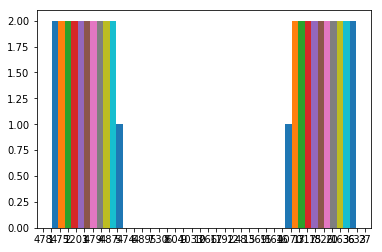

In [26]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

data = [1, 2, 1, 3, 3, 1, 4, 2]

%matplotlib inline

import matplotlib.pyplot as plt

teste = {}

for lessons, account_key in lessons_by_account.items():
    teste[account_key] = lessons
plt.hist(teste.items(), bins=2)



## Improving Plots and Sharing Findings

In [27]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.

passing = {}
for engagement in passing_engagement:
    account_key = engagement['account_key']
    if account_key not in passing :
        if engagement['num_courses_visited'] > 0:
            passing[account_key] = 1
        else:
            passing[account_key] = 0
    else:
        if engagement['num_courses_visited'] > 0:
            passing[account_key] += 1

non_passing = {}
for engagement in non_passing_engagement:
    account_key = engagement['account_key']
    if account_key not in passing :
        if engagement['num_courses_visited'] > 0:
            non_passing[account_key] = 1
        else:
            non_passing[account_key] = 0
    else:
        if engagement['num_courses_visited'] > 0:
            non_passing[account_key] += 1

Text(0.5,1,'Distribution of classroom visits in the first week for students who pass the subway project')

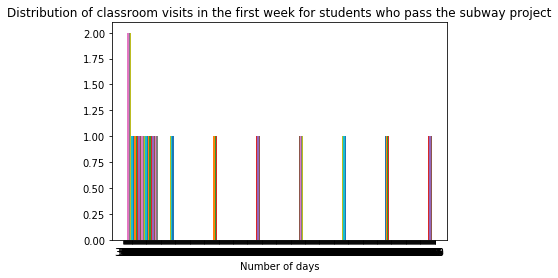

In [28]:
## Graphic
import seaborn as sns
%matplotlib inline

plt.hist(passing.items(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who pass the subway project')




Text(0.5,1,'Distribution of classroom visits in the first week for students who do not pass the subway project')

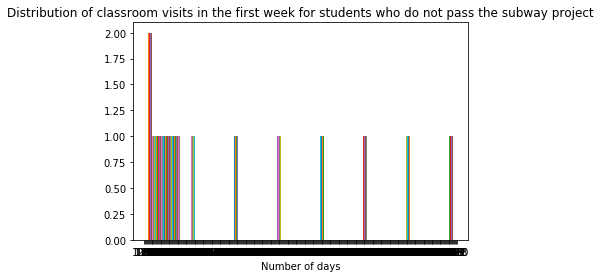

In [29]:
%matplotlib inline

plt.hist(non_passing.items(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who do not pass the subway project')